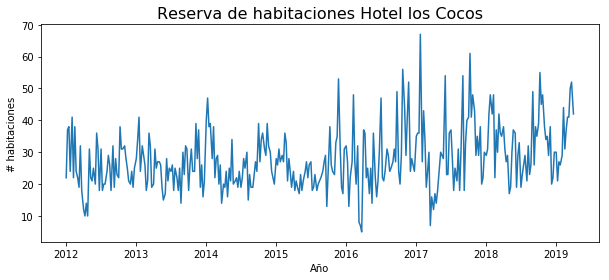

In [5]:
import re
import os
import sys
import datetime
import itertools
import math
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 4)
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss	

#serie de tiempo en grafico

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
ts = data['#guests']

#imprimir la serie de tiempo y guardarla en la carpeta imagen como referencia
plt.plot(data)
plt.title('Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel('# habitaciones')
plt.xlabel('Año')
plt.savefig('./img/serie_huespedes.png')
plt.show()

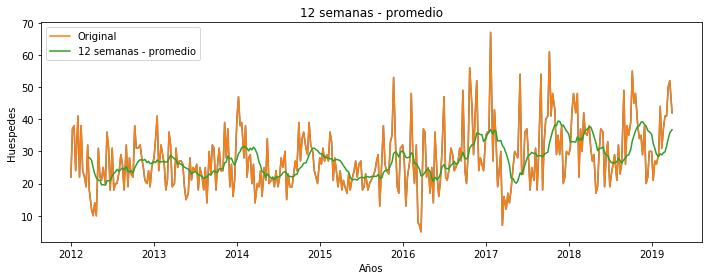

In [10]:

#analisis de tendencia
#fig.set_figwidth(14);
#fig.set_figheight(8);
plt.plot(data)
# lower right
plt.plot(ts.index, ts, label='Original');
plt.plot(ts.index, ts.rolling(window=12).mean(), label='12 semanas - promedio');
plt.xlabel("Años");
plt.ylabel("Huespedes");
plt.title("12 semanas - promedio");
plt.legend(loc='best');
plt.tight_layout();
plt.savefig('./img/tendencia.png')
plt.show()

In [29]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

# #leer la data del excel de los huespedes.csv
# df = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

# df['Month'] = df.index.strftime('%b')
# df['Year'] = df.index.year

# month_names = pd.date_range(start='2008-01-01', periods=12, freq='MS').strftime('%b')
# df_piv_line = df.pivot(index='Month', columns='Year', values='#guests')
# df_piv_line = df_piv_line.reindex(index=month_names)
# df_piv_line

In [31]:
# # create line plot
# df_piv_line.plot(colormap='jet');
# plt.title('Seasonal Effect per Month', fontsize=24)
# plt.ylabel('Huespuedes')
# plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
# plt.savefig('./img/seasonal_effect_lines.png')
# plt.show()

In [35]:
y = data['#guests']
def adf_test(y):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)
adf_test(y)    

Results of Augmented Dickey-Fuller test:
test statistic          -6.68622
p-value                  0.00000
# of lags                2.00000
# of observations      346.00000
Critical Value (1%)     -3.44939
Critical Value (5%)     -2.86993
Critical Value (10%)    -2.57124
dtype: float64


In [36]:
def ts_diagnostics(y, lags=None, title='', filename=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    
    rolling_mean = y.rolling(12).mean()
    rolling_std = y.rolling(12).std()
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson');
    rolling_std.plot(ax=ts_ax, color='darkslateblue');
    plt.legend(loc='best')
    ts_ax.set_title(title, fontsize=24);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.savefig('./img/{}.png'.format(filename))
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return

No handles with labels found to put in legend.


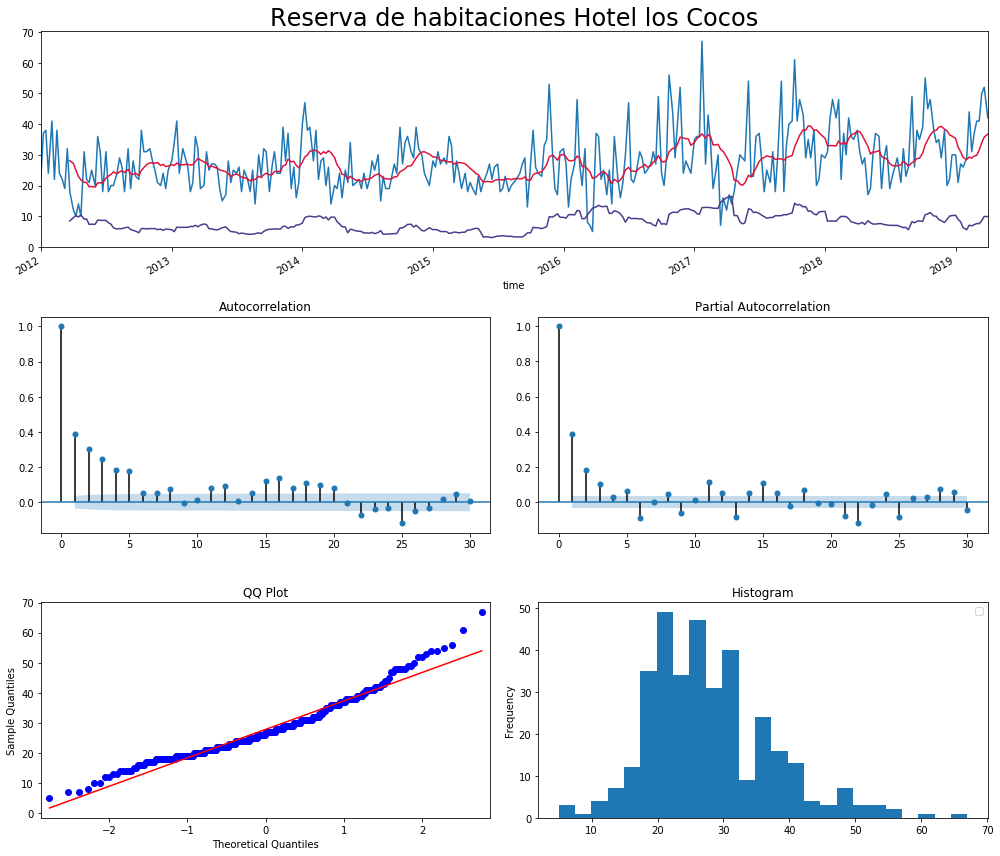

Results of Dickey-Fuller test:
test statistic          -6.68622
p-value                  0.00000
# of lags                2.00000
# of observations      346.00000
Critical Value (1%)     -3.44939
Critical Value (5%)     -2.86993
Critical Value (10%)    -2.57124
dtype: float64


In [37]:
ts_diagnostics(y, lags=30, title='Reserva de habitaciones Hotel los Cocos', filename='adf_data')


No handles with labels found to put in legend.


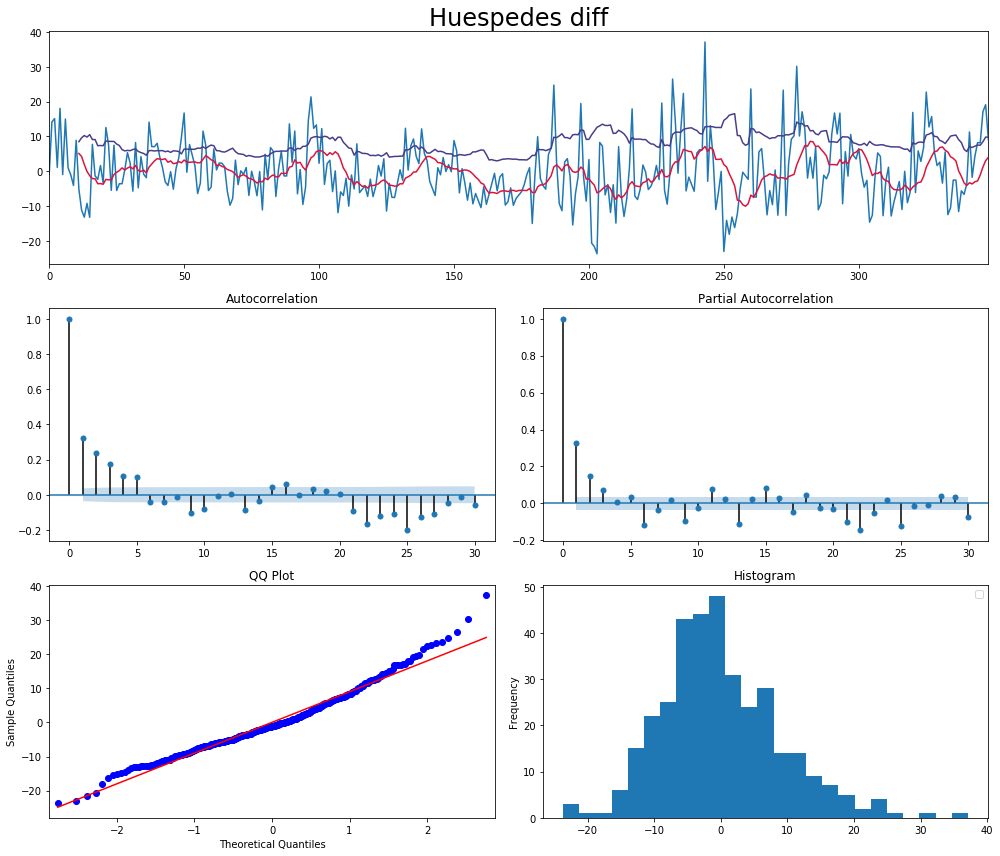

Results of Dickey-Fuller test:
test statistic          -6.58325
p-value                  0.00000
# of lags                5.00000
# of observations      343.00000
Critical Value (1%)     -3.44956
Critical Value (5%)     -2.87000
Critical Value (10%)    -2.57128
dtype: float64


In [38]:
from scipy import signal
y_detrend = signal.detrend(y)
y_diff = np.diff(y)
ts_diagnostics(y_detrend, lags=30, title='Huespedes diff', filename='adf_diff')

No handles with labels found to put in legend.


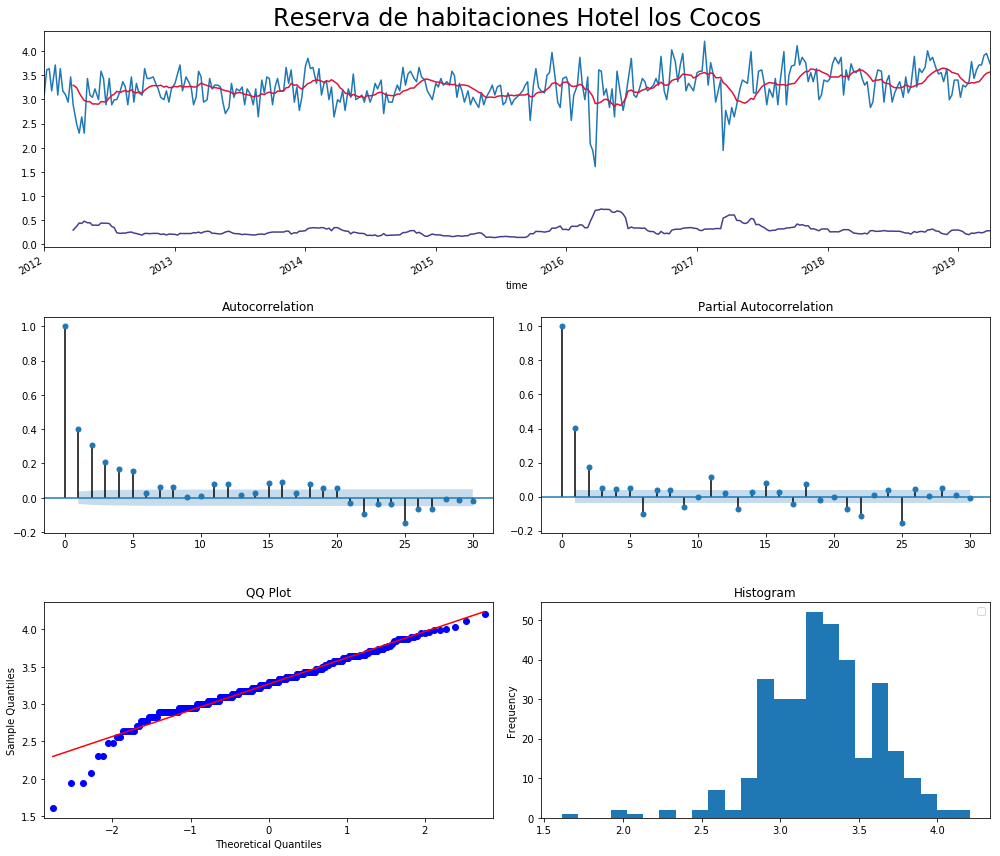

Results of Dickey-Fuller test:
test statistic          -8.37996
p-value                  0.00000
# of lags                1.00000
# of observations      347.00000
Critical Value (1%)     -3.44934
Critical Value (5%)     -2.86991
Critical Value (10%)    -2.57123
dtype: float64


In [39]:
y_log = np.log(y)
ts_diagnostics(y_log, lags=30, title='Reserva de habitaciones Hotel los Cocos', filename='adf_log')

No handles with labels found to put in legend.


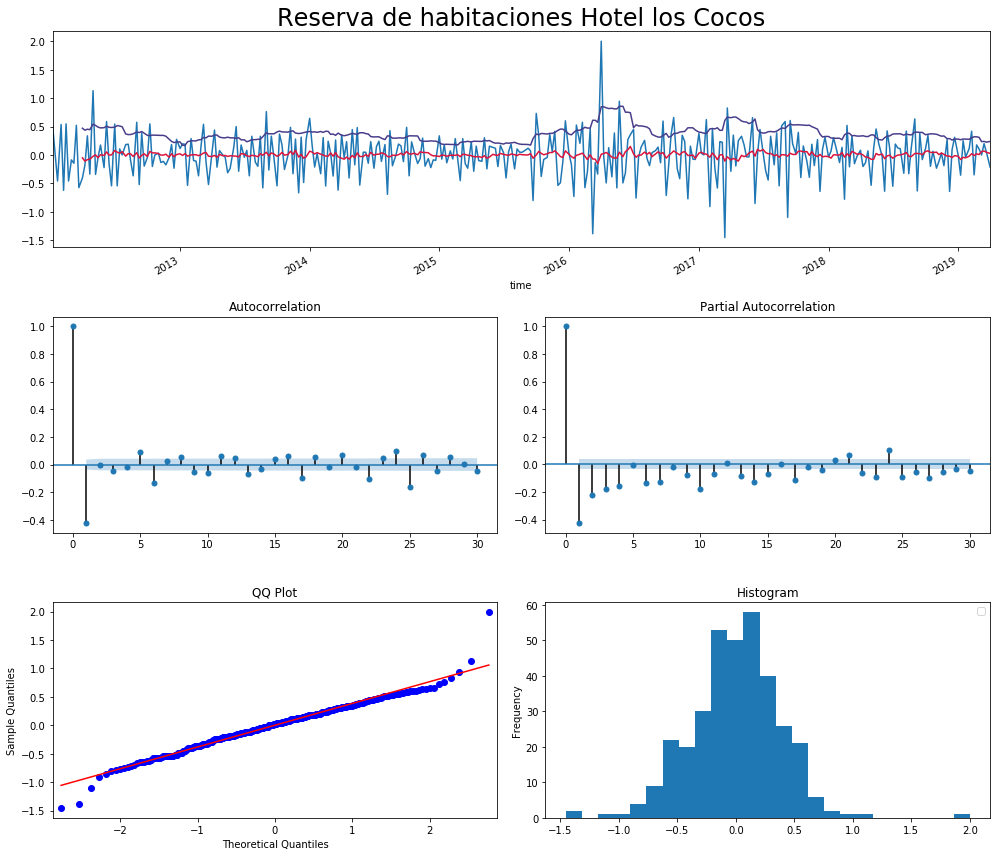

Results of Dickey-Fuller test:
test statistic          -9.43953
p-value                  0.00000
# of lags                9.00000
# of observations      338.00000
Critical Value (1%)     -3.44985
Critical Value (5%)     -2.87013
Critical Value (10%)    -2.57135
dtype: float64


In [40]:
y_log_diff = np.log(y).diff().dropna()
ts_diagnostics(y_log_diff, lags=30, title='Reserva de habitaciones Hotel los Cocos', filename='adf_log_diff')

No handles with labels found to put in legend.


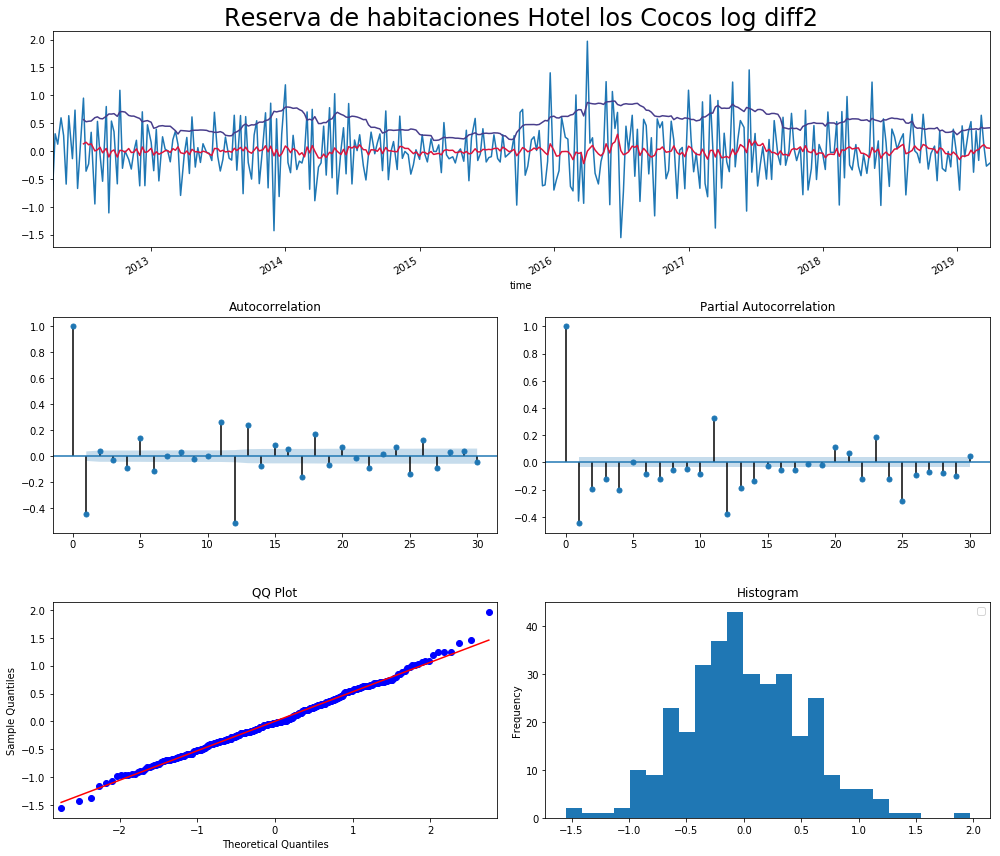

Results of Dickey-Fuller test:
test statistic          -8.69316
p-value                  0.00000
# of lags               13.00000
# of observations      322.00000
Critical Value (1%)     -3.45082
Critical Value (5%)     -2.87056
Critical Value (10%)    -2.57157
dtype: float64


In [41]:
y_log_diff2 = np.log(y).diff(1).diff(12).dropna()
ts_diagnostics(y_log_diff2, lags=30, title='Reserva de habitaciones Hotel los Cocos log diff2', filename='adf_log_diff2')

In [42]:
#prediccion SARIMA
# split into training and test sets
y = df['#guests']
y_train = y[:'2018']
y_test = y['2019':]
print('TEST')
print(y_test)
print('TRAIN')
print(y_train)

TEST
time
2019-01-01    30
2019-01-08    21
2019-01-15    27
2019-01-22    26
2019-02-01    29
2019-02-08    44
2019-02-15    31
2019-02-22    37
2019-03-01    41
2019-03-08    41
2019-03-15    50
2019-03-22    52
2019-04-01    42
Name: #guests, dtype: int64
TRAIN
time
2012-01-01    22
2012-01-08    37
2012-01-15    38
2012-01-22    24
2012-02-01    41
2012-02-08    22
2012-02-15    38
2012-02-22    24
              ..
2018-11-01    38
2018-11-08    34
2018-11-15    35
2018-11-22    29
2018-12-01    38
2018-12-08    20
2018-12-15    22
2018-12-22    30
Name: #guests, Length: 336, dtype: int64


In [43]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [45]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            res = tmp_mdl.fit()

#             print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))



Best SARIMAX(1, 0, 1)x(0, 1, 1, 12)12 model - AIC:2339.9400164497793


2478.749864341595
                                 Statespace Model Results                                 
Dep. Variable:                            #guests   No. Observations:                  336
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 13)   Log Likelihood               -1236.375
Date:                            Fri, 17 May 2019   AIC                           2478.750
Time:                                    15:37:47   BIC                           2490.074
Sample:                                         0   HQIC                          2483.271
                                            - 336                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6757      0.039    -17.424      0.000      -0.752      -0.600
ar.S.L13      -0.

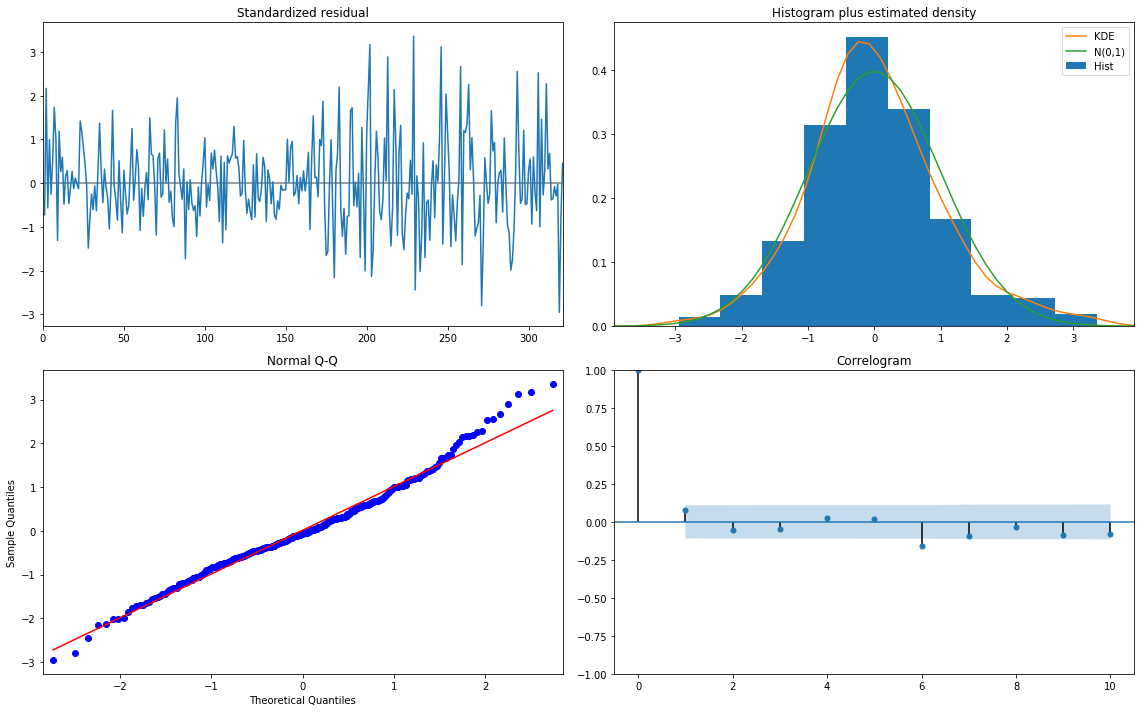

In [46]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

# print statistics
print(res.aic)
print(res.summary())

from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
print(chi)
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

In [47]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
chi

142.13816003902645

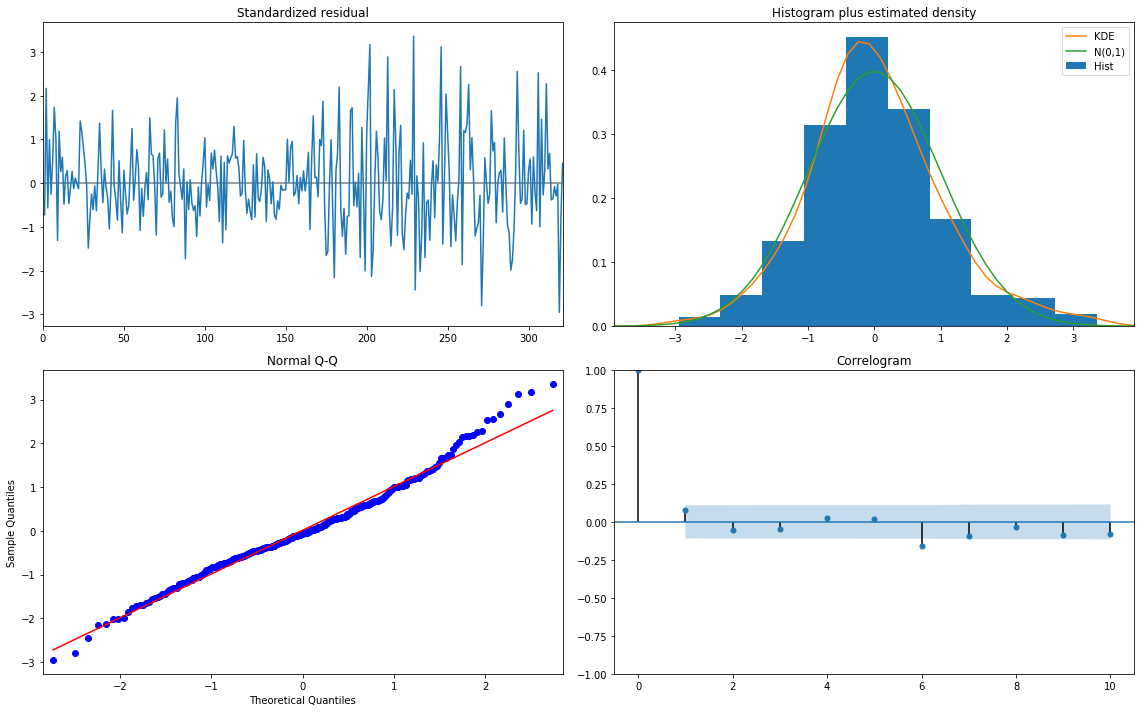

In [48]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.savefig('./img/arima_resid.png')
plt.show()

In [51]:
y_hat = pred.predicted_mean
y_true = y['2016-12-01':]

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

NameError: name 'pred' is not defined

In [64]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

print(y_train)
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2018-12-22'), 
                          end=pd.to_datetime('2019-04-01'),
                          dynamic=True)
pred_ci = pred.conf_int()

# plot in-sample-prediction
ax = y['2012':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
print('sdsdsds')
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date');
ax.set_ylabel('Guests');
plt.legend(loc='upper left');
plt.savefig('./img/in_sample_pred.png')
plt.show()

time
2012-01-01    22
2012-01-08    37
2012-01-15    38
2012-01-22    24
2012-02-01    41
2012-02-08    22
2012-02-15    38
2012-02-22    24
              ..
2018-11-01    38
2018-11-08    34
2018-11-15    35
2018-11-22    29
2018-12-01    38
2018-12-08    20
2018-12-15    22
2018-12-22    30
Name: #guests, Length: 336, dtype: int64


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

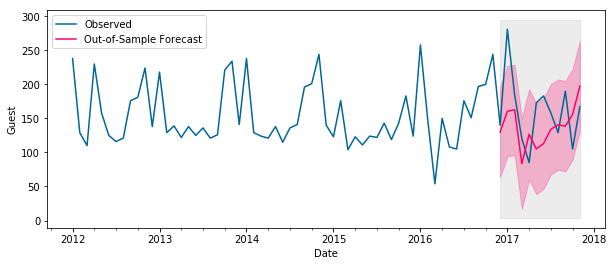

In [55]:
# predict out of sample and find confidence bounds
pred_out = res.get_prediction(start=pd.to_datetime('2016-12-01'), 
                              end=pd.to_datetime('2017-11-01'), 
                              dynamic=False, full_results=True)
pred_out_ci = pred_out.conf_int()

# plot time series and out of sample prediction
ax = y['2012':].plot(label='Observed', color='#006699')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='#ff0066')
ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='#ff0066', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-12-01'), y.index[-1], alpha=.15, zorder=-1, color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('Guest')
plt.legend()
plt.savefig('./img/out_of_sample_pred.png')
plt.show()

In [56]:
# extract the predicted and true values of our time series
y_hat = pred_out.predicted_mean
y_true = y['2016-12-01':]

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 2879.32 MSE (53.66 RMSE)


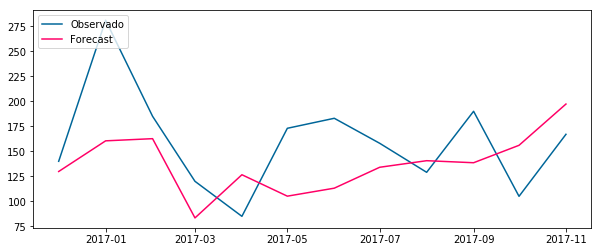

In [57]:

plt.plot(y_true, label='Observado', color='#006699')
plt.plot(y_hat, label='Forecast', color='#ff0066')
ax.set_xlabel('Date')
ax.set_ylabel('Guests')
plt.legend(loc='upper left');
plt.savefig('./img/out_of_sample_comparison.png')
plt.show()

In [58]:
from math import sqrt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error
rms = sqrt(mean_squared_error(y_true, y_hat))
print('MSE',rms)
#MADE
#print(y_test)
#print(pred)
real=np.array(y_true)
print(real)
predi=np.array(y_hat)
print(predi)

MSE 53.65925785049935
[140 281 185 120  85 173 183 158 129 190 105 167]
[129.81004 160.45781 162.62898  83.41254 126.57192 105.15917 113.13904
 134.04339 140.61051 138.57359 155.98467 197.2397 ]
